# Installation & Setup

Before we proceed, please install the following packages:

In [1]:
] add GeoStats StratiGraphics DirectGaussianSimulation Plots

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [2]:
using Random; Random.seed!(2019); # make sure this tutorial is reproducible

# Creating surfaces

First, we demonstrate how  Markov-Poisson sampling can be used to generate random surfaces of a 3D stratigraphic model.

We start by defining a set of 2D geostatistical processes:

In [3]:
using GeoStats
using StratiGraphics
using DirectGaussianSimulation

proc₁ = DirectGaussSim(:land => (variogram=GaussianVariogram(range=50.),))
proc₂ = DirectGaussSim(:land => (variogram=GaussianVariogram(range=100.),))

procs = [proc₁, proc₂]

┌ Info: Recompiling stale cache file /home/juliohm/.julia/compiled/v1.1/StratiGraphics/Ggcdv.ji for StratiGraphics [a9b2fd8e-637c-54e3-ac72-d5fce90e44cf]
└ @ Base loading.jl:1184


2-element Array{DirectGaussSim,1}:
 DirectGaussSim
 DirectGaussSim

In this example, we define two Gaussian processes with different horizontal ranges, namely `50` and `100`. This processes represent smooth "depositional" processes as indicated by the `GaussianVariogram` model.

Having a set of processes defined to evolve a landscape, we need transition probabilities between these processes in order to build stratigraphy over time. Here we say that the two processes are balanced (i.e. 50% / 50% chance in the long run):

In [4]:
P = [0.5 0.5
     0.5 0.5]

2×2 Array{Float64,2}:
 0.5  0.5
 0.5  0.5

Finally, we specify a duration process that determines the (random) amount of time that each process takes before a new transition:

In [5]:
ΔT = ExponentialDuration(1.0)

ExponentialDuration(1.0)

We create a geological environment with the components defined above:

In [6]:
env = Environment(procs, P, ΔT)

Environment(DirectGaussSim[DirectGaussSim, DirectGaussSim], [0.5 0.5; 0.5 0.5], ExponentialDuration(1.0))

Given an initial state (i.e. flat land), and a number of epochs, we can simulate the environment to produce a geological record:

In [7]:
nepochs = 10 # number of surfaces to simulate

init = LandState(zeros(50,50)) # each surface is a 50x50 image

record = simulate(env, init, nepochs);

From the record, we can extract the surfaces that make the stratigraphic model. Two options are available for stacking the surfaces, they are `:erosional` (default) in which case the surfaces are eroded backward in time, and `:depositional` in which case the surfaces are deposited forward in time:

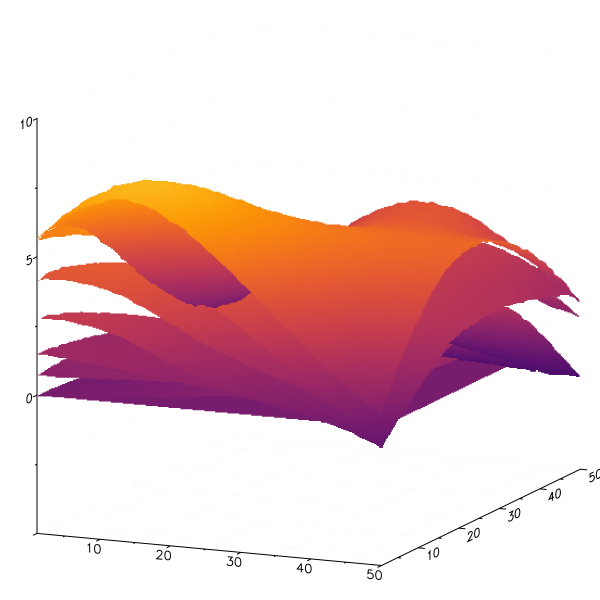

In [8]:
using Plots

strata = Strata(record)

plot(strata, size=(600,600))

We can convert the stratigraphic model into a 3D voxel model by specifying a vertical resolution:

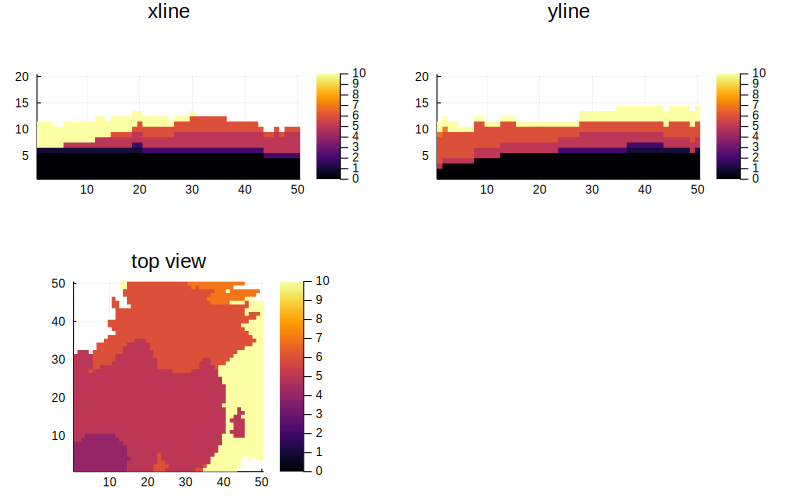

In [9]:
model = voxelize(strata, 20) # 50x50x20 voxel model

xslice = rotr90(model[25,:,:])
yslice = rotr90(model[:,25,:])
zslice = model[:,:,8]

px = heatmap(xslice, title="xline")
py = heatmap(yslice, title="yline")
pz = heatmap(zslice, title="top view")

plot(px, py, pz, size=(800,500), aspect_ratio=:equal, clim=(0,nepochs))

# Putting it all together

We can create many such stratigraphic models by defining a simulation problem for stratigraphy:

In [10]:
problem = SimulationProblem(RegularGrid{Float64}(50,50,20), :strata => Float64, 3)

3D SimulationProblem (unconditional)
  domain:    50×50×20 RegularGrid{Float64,3}
  variables: strata (Float64)
  N° reals:  3

The `StratSim` solver is compliant with the GeoStats.jl API:

In [11]:
solver = StratSim(:strata => (environment=env,))

StratSim
  └─strata
    └─environment ⇨ Environment(DirectGaussSim[DirectGaussSim, DirectGaussSim], [0.5 0.5; 0.5 0.5], ExponentialDuration(1.0))
    └─stack ⇨ :erosional
    └─nepochs ⇨ 10


In [12]:
Random.seed!(2000)

solution = solve(problem, solver)

3D SimulationSolution
  domain: 50×50×20 RegularGrid{Float64,3}
  variables: strata

The solution contains 3 realizations of stratrigraphy, which can be visualized with:

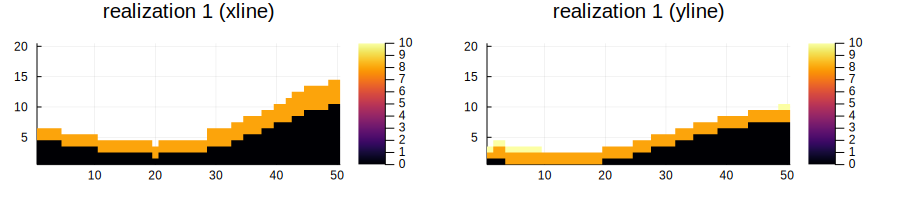

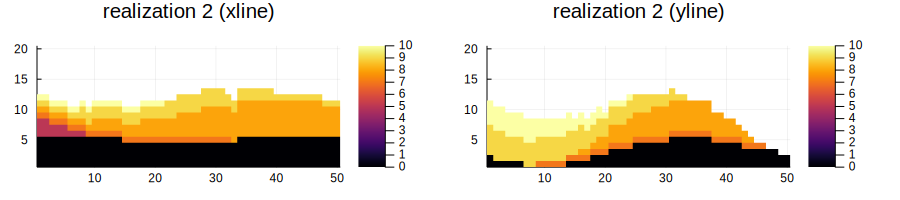

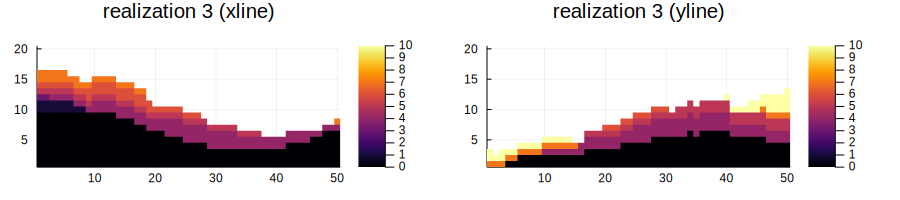

In [13]:
result = digest(solution)

for (i,real) in enumerate(result[:strata])
    xslice = rotr90(real[25,:,:])
    yslice = rotr90(real[:,25,:])
    
    px = heatmap(xslice, title="realization $i (xline)", clim=(0,nepochs))
    py = heatmap(yslice, title="realization $i (yline)", clim=(0,nepochs))
    
    p = plot(px, py, aspect_ratio=:equal, size=(900,200))
    
    display(p)
end